<a href="https://colab.research.google.com/github/nwon24/basel/blob/main/Basel_LSTM_8h.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset,DataLoader,TensorDataset

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error

from datetime import date

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file="/content/drive/MyDrive/Colab Notebooks/Basel_2020-23.csv"
file2="/content/drive/MyDrive/Colab Notebooks/Basel_2024-25.csv"
#file="/content/drive/MyDrive/Colab Notebooks/Basel_2001-25.csv"

df=pd.read_csv(file,delimiter=",",skiprows=10,usecols=[1],encoding="utf-8",header=None)
df2=pd.read_csv(file2,delimiter=",",skiprows=10,usecols=[1],encoding="utf-8",header=None)
nparr=df.to_numpy(dtype=np.float64)
nparr2=df2.to_numpy(dtype=np.float64)


In [ ]:
predwin=8
testhours=365*24
horizon=8
totalhours=nparr.size
train_split=nparr[:-testhours]
test_split=nparr[-testhours:]
valid_split=nparr2


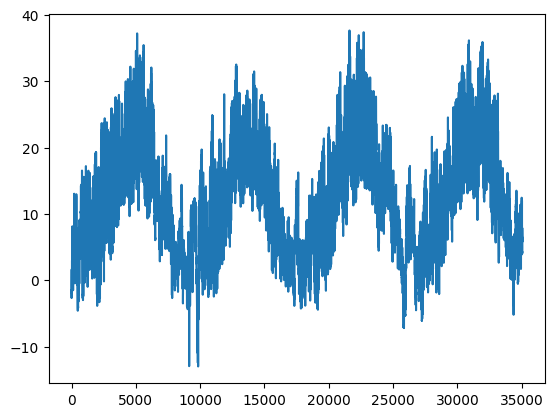

In [ ]:
plt.plot(np.arange(totalhours),nparr)
plt.show()

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
#scaler=MinMaxScaler(feature_range=(-1,1))
train_data=(torch.from_numpy(scaler.fit_transform(train_split)))
test_data=(torch.from_numpy(scaler.transform(test_split)))
valid_data=(torch.from_numpy(scaler.transform(valid_split)))

In [ ]:
def preparexy(data,predwin,horizon):
    n=(len(data)-predwin)//horizon
    x=torch.zeros((n,predwin,1))
    y=torch.zeros((n,horizon,1))
    for i in range(n):
        x[i]=data[i:i+predwin]
        y[i]=data[i+predwin:i+predwin+horizon]
    return x,y

xtrain,ytrain=preparexy(train_data,predwin,horizon)
xtest,ytest=preparexy(test_data,predwin,horizon)
xvalid,yvalid=preparexy(valid_data,predwin,horizon)

In [ ]:
class lstm(nn.Module):
    def __init__(self,inputsize,hiddensize,nlayers,outputsize,batch_first=True,dropout=0.0):
        super().__init__()
        self.inputsize=inputsize
        self.hiddensize=hiddensize
        self.nlayers=nlayers
        self.batch_first=batch_first
        self.outputsize=outputsize
        self.dropout=dropout
        self.lstm=nn.LSTM(self.inputsize,self.hiddensize,self.nlayers,batch_first=self.batch_first,dropout=dropout)
        self.linear=nn.Linear(self.hiddensize,outputsize)

    def forward(self,x):
        out,_=self.lstm(x)
        return self.linear(out[:,-1,:])

In [ ]:
inputsize=1
nlayers=1
hiddensize=128
outputsize=horizon

dropout=0.0
lr=1e-3

model=lstm(inputsize,hiddensize,nlayers,outputsize,dropout=dropout)
lossfn=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=lr)


In [ ]:
batch_size=64
epochs=50

traindataset=TensorDataset(xtrain,ytrain)
trainloader=DataLoader(traindataset,batch_size=batch_size,shuffle=True)
testdataset=TensorDataset(xtest,ytest)
testloader=DataLoader(testdataset,batch_size=batch_size,shuffle=True)

In [ ]:
print(xvalid.size(),yvalid.size())

torch.Size([2192, 8, 1]) torch.Size([2192, 8, 1])


In [ ]:
def validate(model,valid_data,xvalid,yvalid,shape,predwin,horizon,start=None,end=None):
    model.eval()
    with torch.no_grad():
        nhours=len(valid_data)
        n=len(xvalid)
        t=np.arange(nhours)
        forecasts=[]
        for i in range(n):
            y=model(xvalid[i].reshape(shape))
            forecasts.append(y.detach().numpy())
        forecasts=np.array(forecasts).flatten()
        transformed_forecasts=scaler.inverse_transform(forecasts.reshape(-1,1))
        transformed_y=scaler.inverse_transform(yvalid.detach().numpy().reshape(-1,1))

        #plot_forecasts=[]
        # Plot a nice picture - nothing to do with the accuracy metrics
        #if end is None:
        #    end=nhours
        #if start is None:
        #    start=predwin
        #hist=valid_data[:predwin]
        #numel=0
        #while numel<end-predwin:
        #    out=model(hist.reshape(shape).to(torch.float32))
        #   numel+=horizon
        #    hist=valid_data[:numel][-predwin:]
        #    plot_forecasts.append(out.detach().numpy())
        #plot_forecasts=np.array(plot_forecasts).flatten()
        #transformed_plot_forecast=scaler.inverse_transform(plot_forecasts.reshape(-1,1))
        #plt.figure(figsize=(20,20))
        #plt.plot(t[predwin:],transformed_plot_forecast,label="Predicted")
        #plt.plot(t[predwin:],scaler.inverse_transform(valid_data[predwin:].reshape(-1,1)),label="Actual")
        #plt.title("Autoregressive model performance")
        #plt.xlabel("Time (hrs)")
        #plt.ylabel("Temperature ($^circ$C)")
        #plt.legend(loc="best")
        #plt.show()
        #print(plot_forecasts)
        return r2_score(transformed_y,transformed_forecasts), mean_squared_error(transformed_y,transformed_forecasts)

In [ ]:
for epoch in range(epochs):
    model.train()
    trainloss=0.0
    testloss=0.0
    for x,y in trainloader:
        pred=model(x)
        loss=lossfn(pred,y.reshape(pred.shape))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        trainloss+=loss.item()

    model.eval()
    with torch.no_grad():
        for x,y in testloader:
            pred=model(x)
            loss=lossfn(pred,y.reshape(pred.shape))
            testloss+=loss.item()

    print(f"Epoch {epoch}: avg train loss = {trainloss/len(trainloader):.5f}, avg test loss = {testloss/len(testloader):.5f}")
    if (epoch+1)%5==0 and epoch>0:
        torch.save(model.state_dict(), f"/content/drive/MyDrive/Colab Notebooks/Basel_LSTM_{date.today()}_{epoch}e_{nlayers}l.pth")


Epoch 0: avg train loss = 0.00395, avg test loss = 0.00205
Epoch 1: avg train loss = 0.00391, avg test loss = 0.00307


KeyboardInterrupt: 

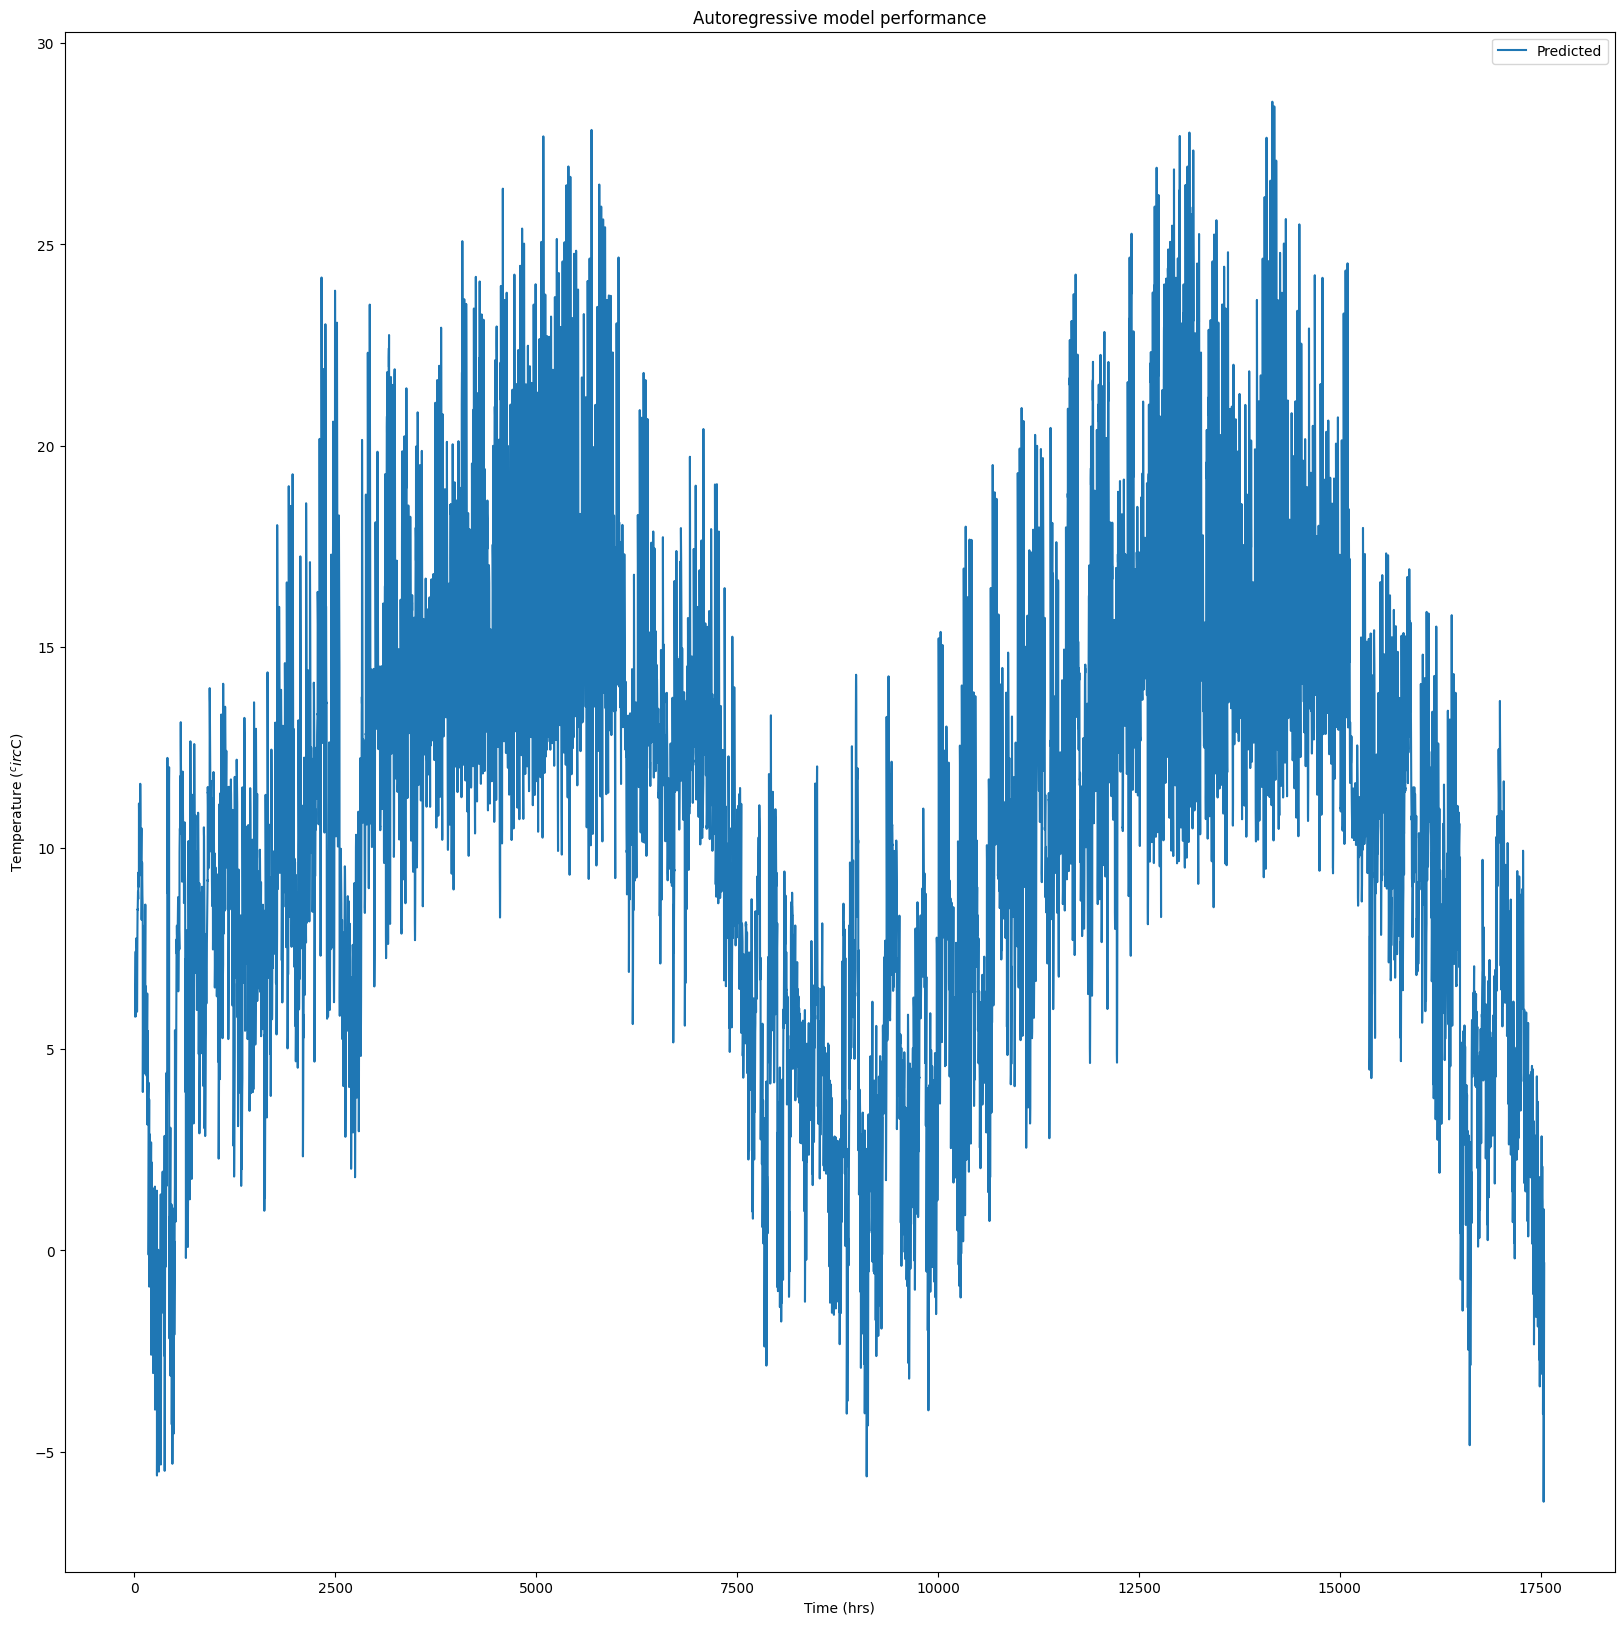

[0.37145865 0.37391672 0.38037166 ... 0.2134346  0.23664543 0.25020278]


(0.721511721611023, 6.745541095733643)

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Basel_LSTM_2026-02-02_49e_1l.pth",weights_only=True))
validate(model,valid_data,xvalid,yvalid,(1,-1,1),predwin,horizon,start=None,end=None)

In [ ]:
model(torch.tensor([[0.4722, 0.4687, 0.4707, 0.4694, 0.4706, 0.4710, 0.4729, 0.4737]]).reshape(1,-1,1))

tensor([[0.4723, 0.4688, 0.4708, 0.4695, 0.4707, 0.4711, 0.4731, 0.4738]],
       grad_fn=<AddmmBackward0>)

In [ ]:
print(model(xvalid[0].reshape((1,-1,1))))
print(valid_split[:predwin])

tensor([[0.3715, 0.3739, 0.3804, 0.3844, 0.3908, 0.3951, 0.4000, 0.4033]],
       grad_fn=<AddmmBackward0>)
[[6.5302453]
 [6.2402453]
 [6.210245 ]
 [6.170245 ]
 [6.1602454]
 [6.130245 ]
 [6.020245 ]
 [6.040245 ]]


In [ ]:
!pip install pennylane
import pennylane as qml
#!pip install pennylane-lightning-gpu
#!pip install custatevec_cu12
#!pip install custatevec-cu11
#!pip install quimb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.6/935.6 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 82.5 MB/s eta 0:00:00


In [ ]:
qpredwin=predwin
qhorizon=horizon
qoutputsize=outputsize
nqubits=qpredwin
#qdev="lightning.gpu"
#qdev="default.qubit"
qdev="lightning.qubit"
#dev=qml.device(qdev,wires=nqubits)
dev=qml.device(qdev)
#dev=qml.device("default.qubit",wires=nqubits)
nlayers=5

@qml.qnode(dev)
def qnode(inputs,weights):
    qubits=weights.shape[1]
    layers=weights.shape[0]
    for i in range(qubits):
        qml.Hadamard(wires=i)
        qml.RY(inputs[i],wires=i)
    #for i in range(len(inputs)):
    #    qml.RY(inputs[i],wires=i%qubits)
    #qml.AmplitudeEmbedding(inputs,wires=range(qubits),pad_with=0,normalize=True)

    for i in range(layers):
        for j in range(qubits-1):
            qml.CNOT(wires=[j,j+1])
        qml.CNOT(wires=[0,qubits-1])
        for j in range(qubits):
            qml.Rot(*weights[i][j],wires=j)
    return [qml.expval(qml.PauliZ(i)) for i in range(qubits)]

In [ ]:
weightshapes={"weights": (nlayers,nqubits,3)}
qlayer=qml.qnn.TorchLayer(qnode,weightshapes)

In [ ]:
class qmodel(nn.Module):
    def __init__(self,nqubits,qlayer,outputsize):
        super().__init__()
        self.qlayer=qlayer
        self.nqubits=nqubits
        self.outputsize=outputsize
        self.lin=nn.Linear(nqubits,outputsize)

    def forward(self,x):
        y=self.qlayer(x)
        return self.lin(y)



In [ ]:
qnn=qmodel(qlayer,qoutputsize)

In [ ]:
def loadqnn(nlayers,nqubits,qoutputsize):
    weightshapes={"weights": (nlayers,nqubits,3)}
    qlayer=qml.qnn.TorchLayer(qnode,weightshapes)
    qnn=qmodel(nqubits,qlayer,qoutputsize)
    return qnn


In [ ]:
qnn.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Basel_QNN_2026-01-28_44e_4l.pth",weights_only=True))

<All keys matched successfully>

In [ ]:
qbatch_size=1
qxtrain,qytrain=preparexy(train_data,qpredwin,qhorizon)
qxtest,qytest=preparexy(test_data,qpredwin,qhorizon)
qtraindataset=TensorDataset(qxtrain,qytrain)
qlr=0.1
qtrainloader=DataLoader(qtraindataset,batch_size=qbatch_size,shuffle=True)
qtestdataset=TensorDataset(qxtest,qytest)
qtestloader=DataLoader(qtestdataset,batch_size=qbatch_size,shuffle=True)

In [ ]:
qoptimizer=torch.optim.Adam(qnn.parameters(),lr=lr)

In [ ]:
for epoch in range(epochs):
    qnn.train()
    trainloss=0.0
    testloss=0.0
    for x,y in qtrainloader:
        pred=qnn(x.flatten())
        #print(pred.shape)
        loss=lossfn(pred,y.reshape(pred.shape))
        qoptimizer.zero_grad()
        loss.backward()
        qoptimizer.step()
        trainloss+=loss.item()

    qnn.eval()
    with torch.no_grad():
        for x,y in qtestloader:
            pred=qnn(x.flatten())
            loss=lossfn(pred,y.reshape(pred.shape))
            testloss+=loss.item()

    print(f"Epoch {epoch}: avg train loss = {trainloss/len(trainloader):.5f}, avg test loss = {testloss/len(testloader):.5f}")
    if (epoch+1)%5==0 and epoch>0:
        torch.save(qnn.state_dict(), f"/content/drive/MyDrive/Colab Notebooks/Basel_QNN_{date.today()}_{epoch}e_{nlayers}l.pth")


Epoch 0: avg train loss = 1.17319, avg test loss = 0.41962
Epoch 1: avg train loss = 0.48883, avg test loss = 0.24777
Epoch 2: avg train loss = 0.38812, avg test loss = 0.23391
Epoch 3: avg train loss = 0.34972, avg test loss = 0.15867
Epoch 4: avg train loss = 0.32917, avg test loss = 0.13295
Epoch 5: avg train loss = 0.31488, avg test loss = 0.27630
Epoch 6: avg train loss = 0.30208, avg test loss = 0.20445
Epoch 7: avg train loss = 0.28920, avg test loss = 0.20356
Epoch 8: avg train loss = 0.28257, avg test loss = 0.12487
Epoch 9: avg train loss = 0.27419, avg test loss = 0.14946
Epoch 10: avg train loss = 0.27364, avg test loss = 0.13517
Epoch 11: avg train loss = 0.26461, avg test loss = 0.23312
Epoch 12: avg train loss = 0.26264, avg test loss = 0.15687
Epoch 13: avg train loss = 0.26020, avg test loss = 0.16522
Epoch 14: avg train loss = 0.25755, avg test loss = 0.26439
Epoch 15: avg train loss = 0.25583, avg test loss = 0.11802
Epoch 16: avg train loss = 0.25424, avg test loss 

17536


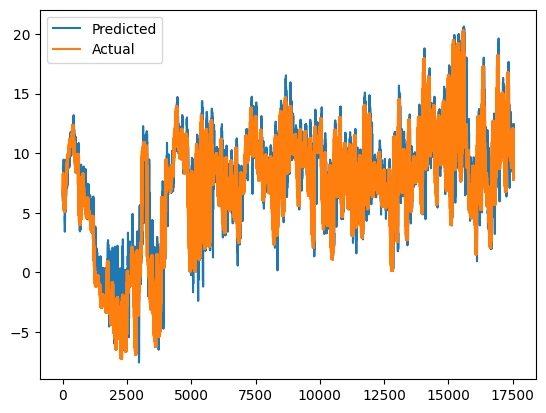

0.7480536699295044

In [ ]:
# 5 layers
qnn=loadqnn(5,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Basel_QNN_2026-02-03_49e_5l.pth",weights_only=True))
validate(qnn,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)

17536


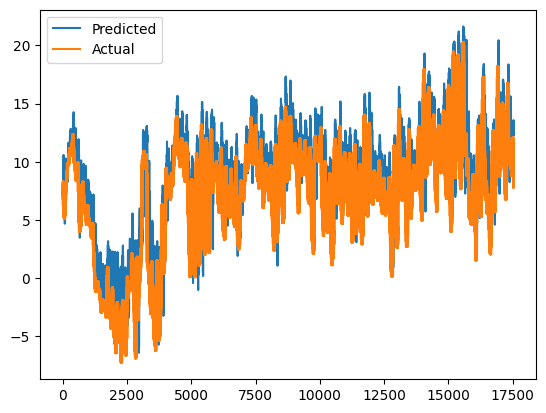

0.6783298254013062

In [ ]:
# 4 layers
qnn=loadqnn(4,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Basel_QNN_2026-02-02_49e_4l.pth",weights_only=True))
validate(qnn,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)

17536


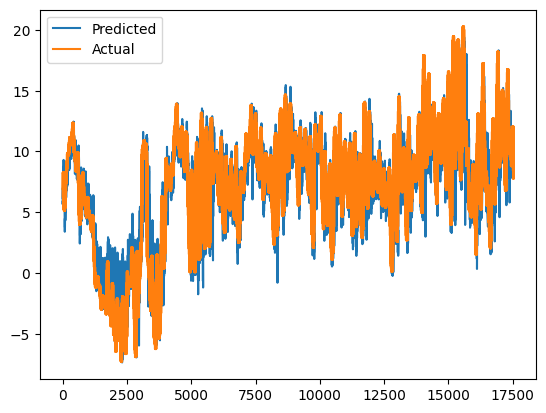

0.7588850855827332

In [ ]:
# 3 layers
qnn=loadqnn(3,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Basel_QNN_2026-02-02_49e_3l.pth",weights_only=True))
validate(qnn,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)

17536


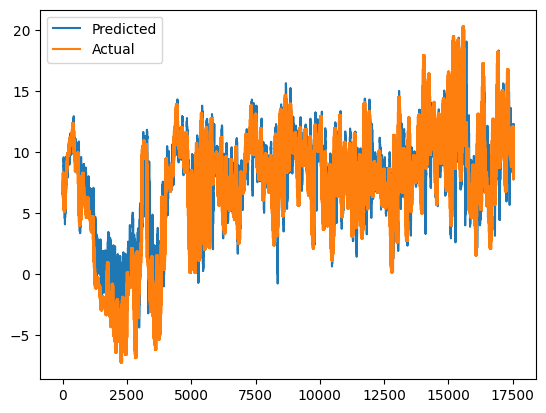

0.7253015041351318

In [ ]:
# 2 layers
qnn=loadqnn(2,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Basel_QNN_2026-02-02_49e_2l.pth",weights_only=True))
validate(qnn,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)

17536


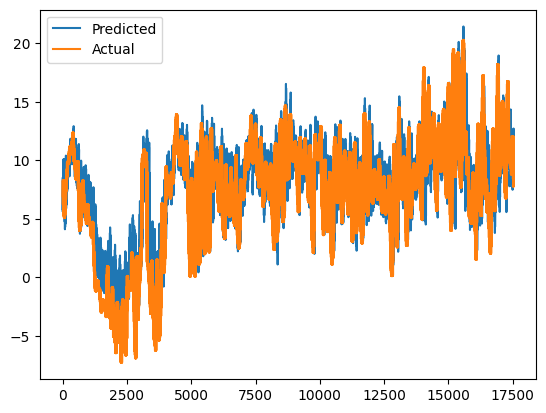

0.6514094471931458

In [ ]:
# 1 layer
qnn=loadqnn(1,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Basel_QNN_2026-02-02_49e_1l.pth",weights_only=True))
validate(qnn,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)

In [ ]:
print(qnn(xvalid[0].reshape(-1)))
print(yvalid[0])

tensor([0.3913, 0.3973, 0.4051, 0.4069, 0.4110, 0.4137, 0.4141, 0.4164],
       grad_fn=<ViewBackward0>)
tensor([[0.3808],
        [0.3917],
        [0.4033],
        [0.4162],
        [0.4187],
        [0.4183],
        [0.4203],
        [0.4162]])


In [ ]:
    qsavepath=f"/content/drive/MyDrive/Colab Notebooks/Basel_QNN_2201.pth"

In [ ]:
torch.save(qnn.state_dict(),f"/content/drive/MyDrive/Colab Notebooks/Basel_QNN_{date.today()}_{nlayers}l_lightning.pth")

In [ ]:
qnn.load_state_dict(torch.load(f"/content/drive/MyDrive/Colab Notebooks/Basel_QNN_2301.pth",weights_only=True))

<All keys matched successfully>

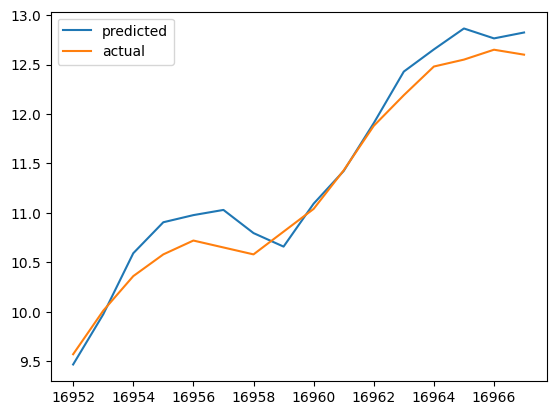

0.9537613050895613

In [ ]:
visualisetest(qnn,qxtest,(-1),qpredwin)

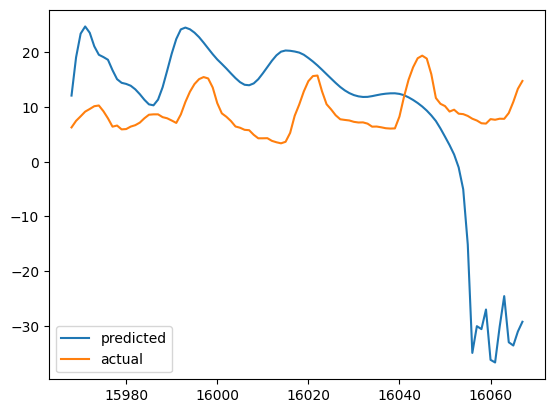

-20.406783413295717

In [ ]:
visualsubs(qnn,qxtest,(-1),qpredwin)